<a href="https://colab.research.google.com/github/sameepshrestha/image-classificcation-/blob/main/simpleclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import time 
import os 

In [ ]:
for f in os.listdir('/content/drive/My Drive'):
    if f.endswith('jpg'):
      os.remove(os.path.join('/content/drive/My Drive/',f))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array

In [ ]:
datagen=ImageDataGenerator(
    rotation_range=30,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    horizontal_flip=True,
    fill_mode='nearest')


In [ ]:
directory='/content/drive/My Drive/classification/'
for dir in ['cat_size_100','dog_size_100']:
  for f in os.listdir(os.path.join(directory,dir)):
    if f.endswith('jpg'):
      img = load_img(directory+dir+'/'+str(f))
      x = img_to_array(img)
      x = x.reshape((1,)+x.shape)
#the augmented data is then wriiten in the directory 
      i=0
      for batch in datagen.flow(x,batch_size=1,save_to_dir=os.path.join('/content/drive/My Drive/augmented_data/'+str(dir)),save_prefix=dir,save_format='jpg'):
        i=i+1
        if i==6:
          break

In [ ]:
dataset1=tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/augmented_data',labels='inferred',
    label_mode='int', class_names=['cat_size_100','dog_size_100'], batch_size=32, image_size=(256, 256), shuffle=True,
     seed=1113,validation_split=.1, subset='training', interpolation='bilinear', follow_links=False
    )
validation_dataset=tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/augmented_data',labels='inferred',
    label_mode='int', class_names=['cat_size_100','dog_size_100'], batch_size=32, image_size=(256, 256), shuffle=True,
     seed=1113,validation_split=.1, subset='validation', interpolation='bilinear', follow_links=False
    )

Found 4771 files belonging to 2 classes.
Using 4294 files for training.
Found 4771 files belonging to 2 classes.
Using 477 files for validation.


In [ ]:
tf.data.experimental.save(dataset1,'/content/drive/My Drive')
tf.data.experimental.save(validation_dataset,'/content/drive/My Drive')

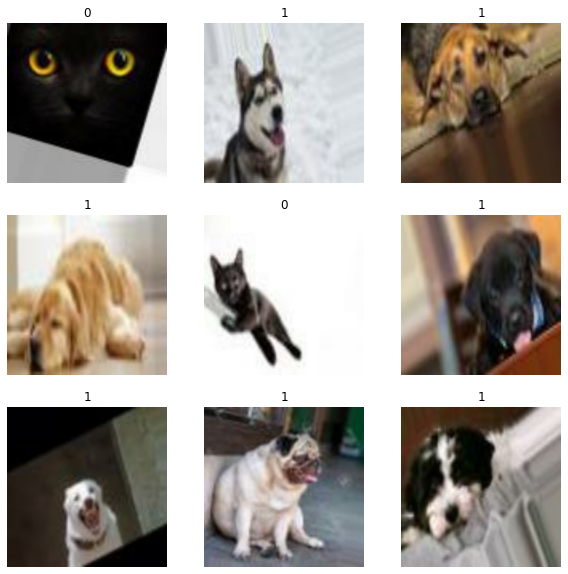

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in dataset1.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
#start=time.time()
#AUTOTUNE=tf.data.experimental.AUTOTUNE
#def normal(image,label):
#  return tf.cast(image,tf.float32)/255.0,label
#dataset1=dataset1.map(normal,num_parallel_calls=AUTOTUNE)
#ends=time.time()
#elapsed=ends-start
#elapsed
print('time=.0408s')

time=.0408s


In [ ]:
normal=tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)

In [ ]:
dataset1=dataset1.map(lambda x,y: (normal(x),y))

In [ ]:
validation_dataset=validation_dataset.map(lambda x,y : (normal(x),y))

In [ ]:
pretrained_model =tf.keras.applications.DenseNet201(
        include_top=False, weights='imagenet', input_shape=[256,256,3])
pretrained_model.trainable = False # tramsfer learning
model2=tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
            
model2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model2.summary()

74842112/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3842      
Total params: 18,325,826
Trainable params: 3,842
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
Epochs=16
historical = model2.fit(dataset1,  
          epochs=Epochs,
          validation_data=validation_dataset)

Epoch 1/16
135/135 [==============================] - 1679s 12s/step - loss: 0.3775 - sparse_categorical_accuracy: 0.8277 - val_loss: 0.2574 - val_sparse_categorical_accuracy: 0.8994
Epoch 2/16
135/135 [==============================] - 34s 249ms/step - loss: 0.2508 - sparse_categorical_accuracy: 0.8966 - val_loss: 0.2405 - val_sparse_categorical_accuracy: 0.8973
Epoch 3/16
135/135 [==============================] - 34s 249ms/step - loss: 0.2140 - sparse_categorical_accuracy: 0.9166 - val_loss: 0.2054 - val_sparse_categorical_accuracy: 0.9245
Epoch 4/16
135/135 [==============================] - 34s 250ms/step - loss: 0.1926 - sparse_categorical_accuracy: 0.9266 - val_loss: 0.1976 - val_sparse_categorical_accuracy: 0.9203
Epoch 5/16
135/135 [==============================] - 34s 251ms/step - loss: 0.1734 - sparse_categorical_accuracy: 0.9369 - val_loss: 0.1725 - val_sparse_categorical_accuracy: 0.9329
Epoch 6/16
135/135 [==============================] - 35s 257ms/step - loss: 0.1606 -

In [ ]:
i=0
for images,labels in dataset1.unbatch():
  i+=1
print(i)

4294


In [ ]:
def accuracy_plot(h,epochs):
  plt.figure(figsize=(14,7))
  plt.subplot(121)
  plt.plot(range(1,epochs+1),h.history['sparse_categorical_accuracy'],'r',label='Training_accuracy')
  plt.plot(range(1,epochs+1),h.history['val_sparse_categorical_accuracy'],'b',label='Validation_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(122)
  plt.plot(range(1,epochs+1),h.history['loss'],'r',label='Training_accuracy')
  plt.plot(range(1,epochs+1),h.history['val_loss'],'b',label='Validation_accuracy')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()

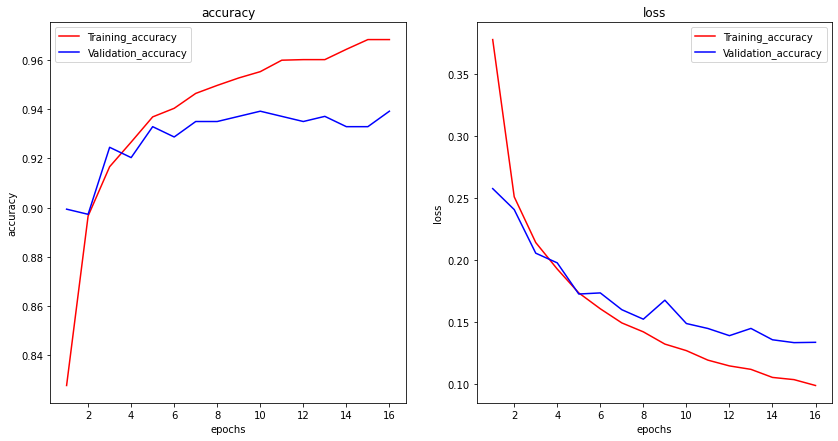

In [ ]:
accuracy_plot(historical,Epochs)